In [1]:
import pymongo
import pandas as pd
import numpy as np
from datetime import date
from dateutil import parser as date_parser
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 9]

In [4]:
from pymongo import MongoClient
client = MongoClient('localhost', 27017)
db = client.trading
symbol = "GOOGL"
collection = db[symbol]

In [5]:
df = pd.DataFrame(list(collection.find()))

In [6]:
df

,_id,date,open,high,low,close,volume,symbol
0,5f6c50202c3f6107f05464e4,2020-09-23T00:00:00.000Z,1452.09,1453.08,1402.680,1409.390,1886299.0,GOOGL
1,5f6c50202c3f6107f05464e5,2020-09-22T00:00:00.000Z,1450.32,1463.97,1429.495,1459.820,1697542.0,GOOGL
2,5f6c50202c3f6107f05464e6,2020-09-21T00:00:00.000Z,1431.62,1440.06,1402.680,1430.140,2845405.0,GOOGL
3,5f6c50202c3f6107f05464e7,2020-09-18T00:00:00.000Z,1488.30,1495.20,1431.620,1451.090,3152788.0,GOOGL
4,5f6c50202c3f6107f05464e8,2020-09-17T00:00:00.000Z,1485.81,1498.66,1462.460,1487.040,2000356.0,GOOGL
...,...,...,...,...,...,...,...,...
4048,5f6c50202c3f6107f05474b4,2004-08-25T00:00:00.000Z,104.76,108.00,103.880,106.000,9188600.0,GOOGL
4049,5f6c50202c3f6107f05474b5,2004-08-24T00:00:00.000Z,111.24,111.60,103.570,104.870,15247300.0,GOOGL
4050,5f6c50202c3f6107f05474b6,2004-08-23T00:00:00.000Z,110.76,113.48,109.050,109.400,18256100.0,GOOGL
4051,5f6c50202c3f6107f05474b7,2004-08-20T00:00:00.000Z,101.01,109.08,100.500,108.310,22834300.0,GOOGL


In [7]:
df2 = df[['date', 'symbol', 'open', 'close', 'high', 'low', 'volume']]

In [8]:
df2['date'] = pd.to_datetime(df2['date']).dt.tz_localize(None)

<ipython-input-8-6ebc0551d850>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['date'] = pd.to_datetime(df2['date']).dt.tz_localize(None)


In [9]:
df2

,date,symbol,open,close,high,low,volume
0,2020-09-23,GOOGL,1452.09,1409.390,1453.08,1402.680,1886299.0
1,2020-09-22,GOOGL,1450.32,1459.820,1463.97,1429.495,1697542.0
2,2020-09-21,GOOGL,1431.62,1430.140,1440.06,1402.680,2845405.0
3,2020-09-18,GOOGL,1488.30,1451.090,1495.20,1431.620,3152788.0
4,2020-09-17,GOOGL,1485.81,1487.040,1498.66,1462.460,2000356.0
...,...,...,...,...,...,...,...
4048,2004-08-25,GOOGL,104.76,106.000,108.00,103.880,9188600.0
4049,2004-08-24,GOOGL,111.24,104.870,111.60,103.570,15247300.0
4050,2004-08-23,GOOGL,110.76,109.400,113.48,109.050,18256100.0
4051,2004-08-20,GOOGL,101.01,108.310,109.08,100.500,22834300.0


In [10]:
df3 = df2[['date', 'close']]

In [11]:
df3 = df3.resample('1440Min', on='date').first().drop('date', 1).reset_index()

In [17]:
df3 = df3.fillna(method='ffill')

In [18]:
predict_nb_day = 14

In [20]:
date = df3[-1:]['date']
for _ in range(predict_nb_day):
    dayplus = {"date": date + pd.DateOffset(1), "close":np.nan}
    df3 = df3.append(pd.DataFrame(dayplus))

In [21]:
df4 = df3.set_index('date')

In [53]:
df4[-5*predict_nb_day:]

,close
date,
2020-07-31,1487.95
2020-08-01,1487.95
2020-08-02,1487.95
2020-08-03,1482.76
2020-08-04,1473.30
...,...
2020-09-25,NaN
2020-09-25,NaN
2020-09-25,NaN


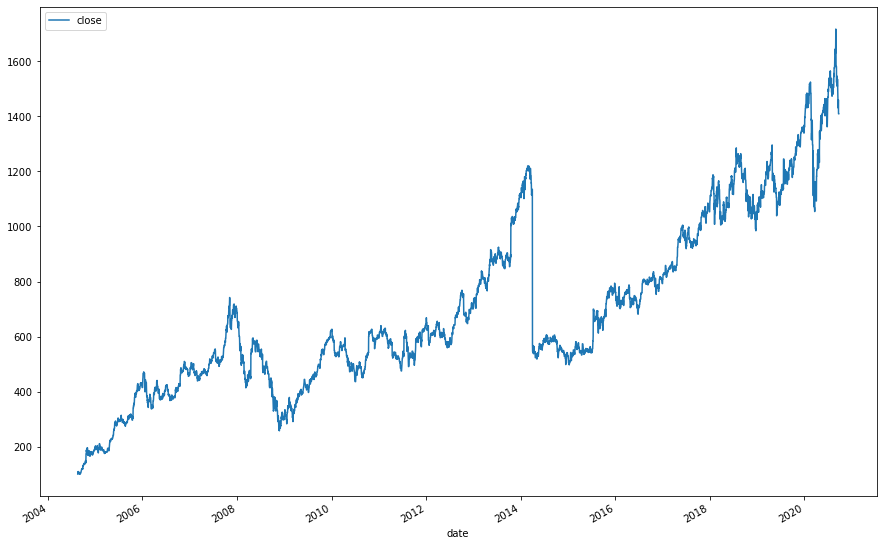

In [54]:
df4.plot(figsize=(15,10))

In [55]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_len = int((len(df4)-predict_nb_day)/10*9)
val_len = len(df4) - train_len -predict_nb_day

X_train = scaler.fit_transform(df4[['close']][0:train_len].values)
X_val = scaler.transform(df4[['close']][train_len:-predict_nb_day].values)
X_test = scaler.transform(df4[['close']][-5*predict_nb_day:].values)

In [56]:
X_test

array([[1.17077327],
       [1.17077327],
       [1.17077327],
       [1.16639533],
       [1.15841551],
       [1.16329956],
       [1.18511333],
       [1.17956288],
       [1.17956288],
       [1.17956288],
       [1.1782554 ],
       [1.16452269],
       [1.18704502],
       [1.19498267],
       [1.1848434 ],
       [1.1848434 ],
       [1.1848434 ],
       [1.19463682],
       [1.22799011],
       [1.21856785],
       [1.24525724],
       [1.24468363],
       [1.24468363],
       [1.24468363],
       [1.25276468],
       [1.27022581],
       [1.30251626],
       [1.28934871],
       [1.29855165],
       [1.29855165],
       [1.29855165],
       [1.29020068],
       [1.31175295],
       [1.36431349],
       [1.29018381],
       [1.24944116],
       [1.24944116],
       [1.24944116],
       [1.24944116],
       [1.20084522],
       [1.22077791],
       [1.20291188],
       [1.19423192],
       [1.19423192],
       [1.19423192],
       [1.18838624],
       [1.21056272],
       [1.191

In [57]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [58]:
X_train, y_train = split_sequence(X_train, 12)
X_val, y_val = split_sequence(X_val, 12)
X_test, y_test = split_sequence(X_test, 12)

In [59]:
n_features=1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], n_features))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))

In [60]:
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

model = Sequential([
    LSTM(50, activation="relu", input_shape=X_train.shape[1:]), # or (X_train.shape[1], 1) or (n_steps, n_features)
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping_cb = EarlyStopping(monitor='val_loss', patience=10,
                          restore_best_weights=True) 

In [63]:
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_val, y_val),
                    batch_size = 32,
                    callbacks=early_stopping_cb)

Epoch 1/100
165/165 [==============================] - 1s 8ms/step - loss: 0.0149 - val_loss: 0.0033
Epoch 2/100
165/165 [==============================] - 1s 7ms/step - loss: 3.3266e-04 - val_loss: 0.0021
Epoch 3/100
165/165 [==============================] - 1s 7ms/step - loss: 3.0293e-04 - val_loss: 0.0011
Epoch 4/100
165/165 [==============================] - 1s 8ms/step - loss: 2.7308e-04 - val_loss: 0.0011
Epoch 5/100
165/165 [==============================] - 1s 8ms/step - loss: 2.4644e-04 - val_loss: 7.1826e-04
Epoch 6/100
165/165 [==============================] - 1s 8ms/step - loss: 2.2595e-04 - val_loss: 6.9127e-04
Epoch 7/100
165/165 [==============================] - 1s 8ms/step - loss: 2.2276e-04 - val_loss: 7.3672e-04
Epoch 8/100
165/165 [==============================] - 1s 7ms/step - loss: 2.1491e-04 - val_loss: 4.9263e-04
Epoch 9/100
165/165 [==============================] - 1s 6ms/step - loss: 2.0740e-04 - val_loss: 5.2280e-04
Epoch 10/100
165/165 [=================

In [64]:
mse_val = model.evaluate(X_val, y_val)

19/19 [==============================] - 0s 3ms/step - loss: 3.4542e-04


In [65]:
rmse = np.sqrt(mse_val)
print(rmse)

0.018585461895049935


In [66]:
mse_test = model.evaluate(X_val, y_val)

19/19 [==============================] - 0s 4ms/step - loss: 3.4542e-04


In [67]:
predicted_close = model.predict(X_test)
predicted_close = scaler.inverse_transform(predicted_close)

In [73]:
prediction = pd.Series(predicted_close[-5*predict_nb_day+12:].reshape(-1), index = df4['close'].iloc[-5*predict_nb_day+12:].index)

In [75]:
prediction

date
2020-08-12    1481.257935
2020-08-13    1500.932373
2020-08-14    1516.457031
2020-08-15    1507.643677
2020-08-16    1502.135864
2020-08-17    1502.620972
2020-08-18    1513.985962
2020-08-19    1551.180542
2020-08-20    1549.734497
2020-08-21    1571.486694
2020-08-22    1576.083496
2020-08-23    1575.715698
2020-08-24    1573.612061
2020-08-25    1583.187134
2020-08-26    1604.359253
2020-08-27    1642.862549
2020-08-28    1635.580322
2020-08-29    1638.038940
2020-08-30    1639.508057
2020-08-31    1641.334717
2020-09-01    1632.211548
2020-09-02    1653.948364
2020-09-03    1717.431152
2020-09-04    1649.860474
2020-09-05    1579.987427
2020-09-06    1573.780518
2020-09-07    1587.259644
2020-09-08    1591.111572
2020-09-09    1538.570557
2020-09-10    1545.522949
2020-09-11    1534.956787
2020-09-12    1522.991943
2020-09-13    1520.081421
2020-09-14    1519.803345
2020-09-15    1512.965820
2020-09-16    1533.449097
2020-09-17    1518.613647
2020-09-18    1489.366211
2020-09

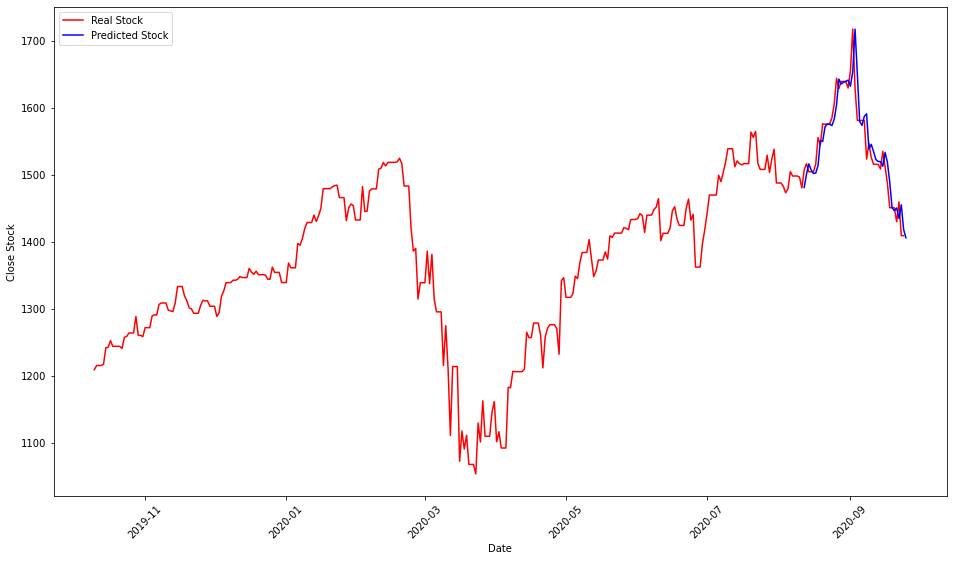

In [74]:
plt.plot(df4['close'][-365:], color = 'r', label = 'Real Stock')
plt.plot(prediction, color = 'b', label = 'Predicted Stock')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Close Stock')
plt.legend()
plt.show()

In [39]:
predict_stock = prediction[-1]

In [40]:
last_stock = df4.iloc[-2]['close']

In [41]:
change_by_day = ((predict_stock) - last_stock)/last_stock
change_by_day

0.008342320442044004

In [42]:
if(change_by_day > 0.05):
    print("You should buy")
elif (change_by_day < -0.05):
    print("Alerte, you should to sell")

In [55]:
from pygooglenews import GoogleNews
import pprint
gn = GoogleNews()
top = gn.top_news()
# gn = GoogleNews(lang = 'cn', country = 'CN')
# top = gn.top_news()
# business = gn.topic_headlines('BUSINESS')
search = gn.search(symbol, when = '1d')
entries = search['entries']   

In [56]:
data = pd.DataFrame(columns = ['Author', 'Date', 'Title', 'Link'])

In [57]:
for entrie in entries :
    data = data.append(pd.Series({'Author': entrie.source.title, \
                           'Date': date_parser.parse(entrie.published),\
                           'Title': entrie.title, \
                           'Link': entrie.link \
                          }), \
                ignore_index=True)

In [60]:
data["Author"].unique()

array(['CFDTrading', 'Benzinga', 'The Motley Fool', 'Motley Fool',
       'Seeking Alpha', 'Metro US', 'InvestorPlace',
       'Chicago Business Journal', 'Nasdaq', 'Yahoo News',
       'Yahoo Finance UK', 'Dividend Investor', 'Yahoo Sports',
       'Investors Chronicle', "Barron's", 'Stock Investor',
       'Yahoo News Canada', 'U.S News & World Report Money', 'RealMoney',
       'India Today', 'TheStreet', 'MarketWatch', 'Brinkwire', 'Forbes',
       'Nintendo-Power', 'GuruFocus.com', 'Reuters', 'Armenian Reporter',
       'BOV News'], dtype=object)

In [62]:
data

,Author,Date,Title,Link
0,CFDTrading,2020-09-23 11:22:00+00:00,Alphabet Inc (GOOGL) 4 Day Down Streak Snapped...,https://www.cfdtrading.com/alphabet-inc-googl-...
1,Benzinga,2020-09-24 08:09:49+00:00,Google Maps Adds Feature To Identify COVID-19 ...,https://www.benzinga.com/news/20/09/17634382/g...
2,The Motley Fool,2020-09-23 11:28:00+00:00,Is Google-Backed Telemedicine Stock Amwell a B...,https://www.fool.com/investing/2020/09/23/is-g...
3,Motley Fool,2020-09-23 15:37:00+00:00,Google Antitrust Lawsuit to Narrowly Focus on ...,https://www.fool.com/investing/2020/09/23/goog...
4,Seeking Alpha,2020-09-24 08:45:00+00:00,"YouTube expands fact-checking, Facebook readie...",https://seekingalpha.com/news/3616881-youtube-...
...,...,...,...,...
61,Nasdaq,2020-09-23 15:10:00+00:00,Why Should You Bet On Cash-Like ETFs Ahead of ...,https://www.nasdaq.com/articles/why-should-you...
62,Nasdaq,2020-09-23 14:47:00+00:00,bluebird-Bristol Myers' CAR T Cell Therapy BLA...,https://www.nasdaq.com/articles/bluebird-brist...
63,Nasdaq,2020-09-23 10:03:00+00:00,3 Little-Known Social Security Facts That Coul...,https://www.nasdaq.com/articles/3-little-known...
64,Armenian Reporter,2020-09-23 16:51:00+00:00,Walmart is using drones to deliver COVID-19 te...,https://www.reporter.am/walmart-is-using-drone...


In [66]:
data.iloc[1]["Link"]

'https://www.benzinga.com/news/20/09/17634382/google-maps-adds-feature-to-identify-covid-19-hot-zones'